In [19]:
import pandas as pd
import nltk
import lightgbm
import yellowbrick
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import feature_extraction
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

stopwords = set(stopwords.words('english'))
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [107]:
model_feats={'num_leaves':30,
                'max_depth':-1,
                'n_estimators':100,
                'learning_rate':.14}

# Steps
1. TFIDF
2. Normalization /  PCA
3. Cluster
4. OHE
5. Predict

In [ ]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [195]:
P = make_pipeline(TfidfVectorizer(
                        stop_words=stopwords, 
                        ngram_range=(1,1),
                        lowercase=True,
                        max_features=1000),
                  DenseTransformer(),
                  OneHotEncoder(),
                  DenseTransformer(),
                  StandardScaler(),
                  PCA(n_components=1000)
                        )
X=P.fit_transform(train['text'])

C:\Users\crysi\anaconda3\envs\ds\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\crysi\anaconda3\envs\ds\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\crysi\anaconda3\envs\ds\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\c

In [190]:
# tfidf = TfidfVectorizer(
#     stop_words=stopwords, 
#     ngram_range=(1,1),
#     lowercase=True,
#     max_features=1000)

# X = tfidf.fit_transform(train['text'])

In [184]:
# ohe=OneHotEncoder()
# X = ohe.fit_transform(X.todense()).todense()

In [185]:
# standard = StandardScaler()
# X = standard.fit_transform(X)

In [186]:
# pca = PCA(n_components=1000)
# X = pca.fit_transform(X)

# Split

In [196]:
X_train,X_test,y_train,y_test = train_test_split(
                                        X, # df 
                                        train['target'],
                                        stratify=train['target'], 
                                        random_state=0, 
                                        test_size=.2,
                                        )

In [197]:
def metrics(m): 
    # AUC
    vis = yellowbrick.ROCAUC(m, classes=[0,1])
    vis.fit(X_train,y_train)
    vis.score(X_test,y_test)
    vis.show()

    # F1 Score
    scores = cross_val_score(m, X_train, y_train, cv=3, scoring='f1')
    print(scores.mean())

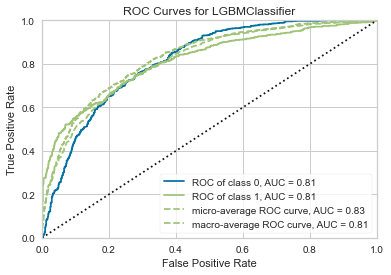

0.6779528643820991


In [198]:
m = lightgbm.LGBMClassifier(
        **model_feats
)
m.fit(X_train, y_train)
metrics(m)

# Write Out

In [199]:
m = lightgbm.LGBMClassifier(
        **model_feats
    )
m.fit(X, train['target'])

LGBMClassifier(learning_rate=0.14, num_leaves=30)

In [200]:
X_val = P.fit_transform(test['text'])

C:\Users\crysi\anaconda3\envs\ds\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\crysi\anaconda3\envs\ds\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\crysi\anaconda3\envs\ds\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\c

In [205]:
preds = m.predict(X_val)
test['target'] = preds
test.set_index('id')['target'].to_csv('tt.csv')

In [202]:
# best = pd.read_csv('best.csv')

In [204]:
best['pred'] = preds
(best['target'] == best['pred']).value_counts()

True     1840
False    1423
dtype: int64

True     2123
False    1140
dtype: int64